# Batch Normalization vs Dropout в качестве регуляризатора между свёрточными слоями.

Следующий эксперимент сравнивает насколько наличие добавленных слоёв Dropout или Batch Normalization между слоями конволюции снижает общую ошибку конволюционной сети. 


#### План эксперимента:
1) В качестве тестовых слоёв будем использовать <b>Batch Normalization</b> и <b>Dropout</b> с разной вероятностью $\in$ $\{ 0.1, 0.3, 0.5 \}$

2) После описания архитектуры модели и её сборки - протестировать её на популярном MNUST dataset'е.

3) Этапы тестирования предполагают смотреть на разницу в Loss'e на train-выборке, между всеми вышеописанными архитектурами: с batch normalization, с dropout-регуляризатором, или вообще без них.

4) В последней части мы сравним полученные результаты в зависимости от нахождения (в порядке) слоя регуляризатора, а именно его положение относительно max-pool слоя - до него и после.


## Гипотеза: 

#### Ошибка (loss) среди всех моделей достигнет совего минимального значения при использовании batch-normalization, при вставке слоя ДО max-pool слоя, между конволюционными слоями.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as utils
from torch.autograd import Variable
from skimage import io, transform
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import PIL

In [2]:
train_dataset = datasets.MNIST(root = './data',
                              train = True,
                              transform = transforms.ToTensor(),
                              download = True)

In [3]:
test_dataset = datasets.MNIST(root='./data',
                             train = False, 
                             transform = transforms.ToTensor())

In [4]:
batch_size = 100


In [5]:
train_load = torch.utils.data.DataLoader(dataset = train_dataset,
                                        batch_size = batch_size,
                                        shuffle = True)

test_load = torch.utils.data.DataLoader(dataset = test_dataset,
                                       batch_size = batch_size,
                                       shuffle = False)

In [6]:
def view_graphs(train_accuracy_history, test_accuracy_history, train_loss_history, test_loss_history, title):
    plt.figure(figsize=(15,4))
    plt.subplot(121)
    plt.title(title + 'Accuracy')
    plt.plot(np.arange(len(train_accuracy_history)) + 1, train_accuracy_history, label='train')
    plt.plot(np.arange(len(test_accuracy_history)) + 1, test_accuracy_history, label='test')
    plt.xlabel('epoch')
    plt.ylabel('accuracy, %')
    plt.legend()
    plt.subplot(122)
    plt.title(title + 'Loss')
    plt.plot(np.arange(len(train_loss_history)) + 1, train_loss_history, label='train')
    plt.plot(np.arange(len(test_loss_history)) + 1, test_loss_history, label='test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

In [51]:
def plotAllModels(history1, history2, history3, history4, history5, title):
    plt.figure(figsize=(12,6))
    # summarize history for accuracy
    xrange = np.arange(len(history1['test_acc'])) + 1
    plt.subplot(121)
    plt.plot(xrange, history1['test_acc'])
    plt.plot(xrange, history2['test_acc'])
    plt.plot(xrange, history3['test_acc'])
    plt.plot(xrange, history4['test_acc'])
    plt.plot(xrange, history5['test_acc'])
    plt.title(title + ' Accuracy')
    plt.ylim((92.5, 100))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Control', 'Batch Norm', 'Dropout (0.1)', 'Dropout (0.3)', 'Dropout (0.5)'], loc='lower right')
    # summarize history for loss
    plt.subplot(122)
    plt.plot(xrange, history1['test_loss'])
    plt.plot(xrange, history2['test_loss'])
    plt.plot(xrange, history3['test_loss'])
    plt.plot(xrange, history4['test_loss'])
    plt.plot(xrange, history5['test_loss'])
    plt.ylim((0, 0.008))
    plt.title(title+ ' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Control', 'Batch Norm', 'Dropout (0.1)', 'Dropout (0.3)', 'Dropout (0.5)'], loc='lower right')
    plt.show()
    return None

In [17]:
def calculate_loss_accuracy(load, model, loss_fn):
    total = 0
    correct = 0
    accuracy = 0
    loss = 0
    for images, labels in load:
        images = images.cuda()
        labels = labels.cuda()
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        loss += loss_fn(outputs, labels).item()
        
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()
    
    accuracy = float(correct) / total * 100
    loss /= len(load.dataset)
    return loss, accuracy

## Постановка эксперимента.


### Архитектура конволюционной сети и описание входных данных.

В каждой из двух следующих секций будет построено 5 конволюционных сетей, каждая из которых будет обучена на наборе данных MNIST. Общая структура архитектуры будет схожа, поэтому была предпринята удачная попытка написать шаблонную архитектуру конволюционной сети с настраиваемыми параметрами размера свёрточной сети (количества свёрток).

Каждая модель будет состоять из 2+ свёрточных слоёв, и как минимум одного полносвязного слоя, состоящего из 10 объектов, испольующего Softmax функцию активации для преобразования выходных данных сети.

### Вариативность задачи
Между каждым свёрточным слоём в одинаковое место был помещен либо Dropout, либо Batch Norm слой, либо он отстутствовал (этот случай тут и далее начнём называть Control - контрольный).

Например, в первой секции сравнивается наличие этих слоёв при условии их нахождения ДО функции активации.

Для более честного тестирования работы Dropout-слоя, предложено исследовать несколько его вариантов с разными вероятностями избавления от связи, такими как $\{0.1, 0.3, 0.5\}$.

В итоге предполагается проверить в 2 захода улучшение относительно местонахождения исследуемых вставляемых слоёв-регуляризаторов, в каждом из которых будет проведено по 5 полных запусков и обучений модели (1 - Control, 1 - Batch Norm, 3 - Dropout).

In [54]:
class CNN(nn.Module):
    def __init__(self, bn, dropout, rate, blocks, before_activation):
        super(CNN, self).__init__()
        
        flatten_size = int(np.cumprod(test_dataset[100][0].shape)[-1] // 4 ** (blocks + 1) * 60)
        
        seq1 = []
        seq1.append(nn.Conv2d(in_channels=test_dataset[0][0].shape[0], out_channels=60, kernel_size=3, stride=1, padding=1))
        if before_activation:
            seq1.append(nn.ReLU())
        if bn:
            seq1.append(nn.BatchNorm2d(60))
        if dropout:
            seq1.append(nn.Dropout(p=rate))
        if not before_activation:
            seq1.append(nn.Softmax())
        
        
        seq1.append(nn.Conv2d(in_channels=60, out_channels=60, kernel_size=3, stride=1, padding=1))
        if before_activation:
            seq1.append(nn.ReLU())
        if bn:
            seq1.append(nn.BatchNorm2d(60))
        if dropout:
            seq1.append(nn.Dropout(p=rate))
        if not before_activation:
            seq1.append(nn.ReLU())
        
        seq1.append(nn.MaxPool2d(kernel_size=2))
        
        for i in range(1, blocks + 1):
            seq1.append(nn.Conv2d(in_channels=60, out_channels=60, kernel_size=3, stride=1, padding=1))
            if before_activation:
                seq1.append(nn.ReLU())    
            if bn:
                seq1.append(nn.BatchNorm2d(60))
            if dropout:
                seq1.append(nn.Dropout(p=rate))
            if not before_activation:
                seq1.append(nn.ReLU())    
            
            seq1.append(nn.Conv2d(in_channels=60, out_channels=60, kernel_size=3, stride=1, padding=1))
            if before_activation:
                seq1.append(nn.ReLU())    
            if bn:
                seq1.append(nn.BatchNorm2d(60))
            if dropout:
                seq1.append(nn.Dropout(p=rate))
            if not before_activation:
                seq1.append(nn.ReLU()) 
            
            seq1.append(nn.MaxPool2d(kernel_size=2))
        
        seq2 = []
        seq2.append(nn.Linear(in_features = flatten_size, out_features = (flatten_size + 10) // 2))
        seq2.append(nn.Dropout(p=0.5))
        seq2.append(nn.ReLU())
        seq2.append(nn.Linear(in_features = (flatten_size + 10) // 2, out_features = 10))
        
        self.seq1 = nn.Sequential(*seq1)
        self.seq2 = nn.Sequential(*seq2)
        self.flat = flatten_size
        
    def forward(self, X):
        out = self.seq1(X)
        out = out.view(-1, self.flat)
        out = self.seq2(out)
        return out

### Функция обёртка над нашим классом, возвращая хронологию Accuracy и Loss на test подвыборке.

In [55]:
def learn_model(blocks, bn, dropout, rate=0, before_activation=False, epochs=10, lr=0.01, title=''):
    model = CNN(bn, dropout, rate, blocks, before_activation).cuda()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    train_loss_history = []
    test_loss_history = []

    train_accuracy_history = []
    test_accuracy_history = []

    iter = 0
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_load):
            iter += 1

            images = images.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()
            outputs = model(images)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        train_loss, train_accuracy = calculate_loss_accuracy(train_load, model, loss_fn)
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)

        test_loss, test_accuracy = calculate_loss_accuracy(test_load, model, loss_fn)
        test_loss_history.append(test_loss)
        test_accuracy_history.append(test_accuracy)

        print(epoch, 'Done! Train Loss: {}, Test Loss: {}, Train Accuracy {:.2f}%, Test Accuracy {:.2f}%'.format(train_loss, test_loss, train_accuracy, test_accuracy))

    view_graphs(train_accuracy_history, test_accuracy_history, train_loss_history, test_loss_history, title=title)
    return {'test_acc' : test_accuracy_history, 'test_loss' : test_loss_history}


## Обучение моделей.

### Сontrol model   (no batch_norm, no dropout, inserted before_activation)

0 Done! Train Loss: 0.011511216262976328, Test Loss: 0.011380757242441177, Train Accuracy 62.48%, Test Accuracy 62.62%
1 Done! Train Loss: 0.0026540743332356216, Test Loss: 0.002500912019237876, Train Accuracy 91.63%, Test Accuracy 91.92%
2 Done! Train Loss: 0.0015813394039248428, Test Loss: 0.0015110013720579444, Train Accuracy 95.08%, Test Accuracy 95.13%
3 Done! Train Loss: 0.0011365418022498488, Test Loss: 0.0010952956682187506, Train Accuracy 96.43%, Test Accuracy 96.24%
4 Done! Train Loss: 0.0010249017621700963, Test Loss: 0.0010435686398530379, Train Accuracy 96.76%, Test Accuracy 96.46%
5 Done! Train Loss: 0.0008116203224752098, Test Loss: 0.0008428443748620339, Train Accuracy 97.43%, Test Accuracy 97.29%
6 Done! Train Loss: 0.0007300409499943877, Test Loss: 0.0007802483507548458, Train Accuracy 97.66%, Test Accuracy 97.40%
7 Done! Train Loss: 0.0007340192243146399, Test Loss: 0.0008116427390952595, Train Accuracy 97.68%, Test Accuracy 97.38%
8 Done! Train Loss: 0.0005832360337

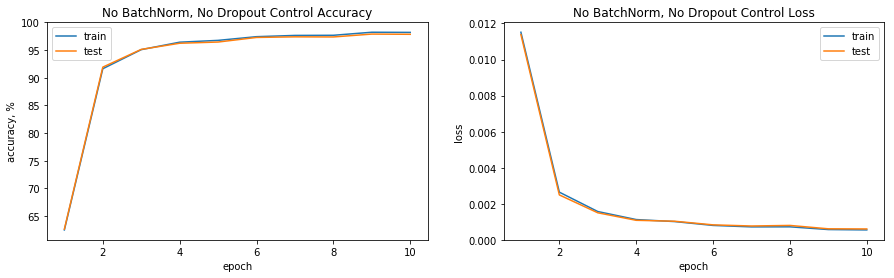

In [56]:
history0_control = learn_model(blocks=1, bn=False, dropout=False, before_activation=True, title='No BatchNorm, No Dropout Control ')

### BatchNorm   (no dropout, inserted before_activation)

0 Done! Train Loss: 0.0008270318277490636, Test Loss: 0.0007251525921747089, Train Accuracy 97.79%, Test Accuracy 98.02%
1 Done! Train Loss: 0.0005297164250475665, Test Loss: 0.0004900012469850481, Train Accuracy 98.55%, Test Accuracy 98.61%
2 Done! Train Loss: 0.0004060117525358995, Test Loss: 0.00039879815995227545, Train Accuracy 98.85%, Test Accuracy 98.74%
3 Done! Train Loss: 0.0003194687891829138, Test Loss: 0.0003560977106972132, Train Accuracy 99.10%, Test Accuracy 98.86%
4 Done! Train Loss: 0.00026158108721332005, Test Loss: 0.0003324736799026141, Train Accuracy 99.26%, Test Accuracy 99.00%
5 Done! Train Loss: 0.00023813339429907502, Test Loss: 0.0003049026990920538, Train Accuracy 99.34%, Test Accuracy 98.99%
6 Done! Train Loss: 0.0002103194508429927, Test Loss: 0.0002816344325110549, Train Accuracy 99.40%, Test Accuracy 99.14%
7 Done! Train Loss: 0.00017760348767236186, Test Loss: 0.0002594850645778934, Train Accuracy 99.48%, Test Accuracy 99.17%
8 Done! Train Loss: 0.000151

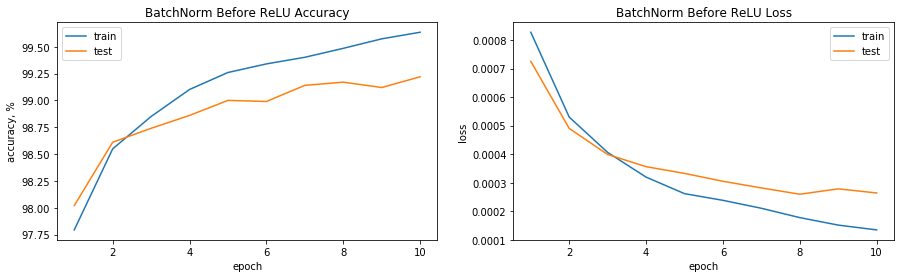

In [29]:
history1_before = learn_model(blocks=1, bn=True, dropout=False, before_activation=True, title='BatchNorm Before ReLU ')

### Dropout   (no batch_norm, dropout rate = 0.1, inserted before_activation)

0 Done! Train Loss: 0.015020175757010777, Test Loss: 0.014859151530265808, Train Accuracy 61.90%, Test Accuracy 63.74%
1 Done! Train Loss: 0.002903681400542458, Test Loss: 0.002795736782811582, Train Accuracy 91.28%, Test Accuracy 91.34%
2 Done! Train Loss: 0.0018408442017932734, Test Loss: 0.0017854678736068308, Train Accuracy 94.40%, Test Accuracy 94.45%
3 Done! Train Loss: 0.0013898856920190157, Test Loss: 0.0014022250664420426, Train Accuracy 95.83%, Test Accuracy 95.80%
4 Done! Train Loss: 0.0011749329881742597, Test Loss: 0.0011545055457158014, Train Accuracy 96.33%, Test Accuracy 96.26%
5 Done! Train Loss: 0.0009663951781578362, Test Loss: 0.0009232840929180384, Train Accuracy 96.98%, Test Accuracy 96.97%
6 Done! Train Loss: 0.0008187915329045305, Test Loss: 0.0008245886628283187, Train Accuracy 97.46%, Test Accuracy 97.38%
7 Done! Train Loss: 0.0007307729299956312, Test Loss: 0.0007274051529238931, Train Accuracy 97.72%, Test Accuracy 97.67%
8 Done! Train Loss: 0.00066407545595

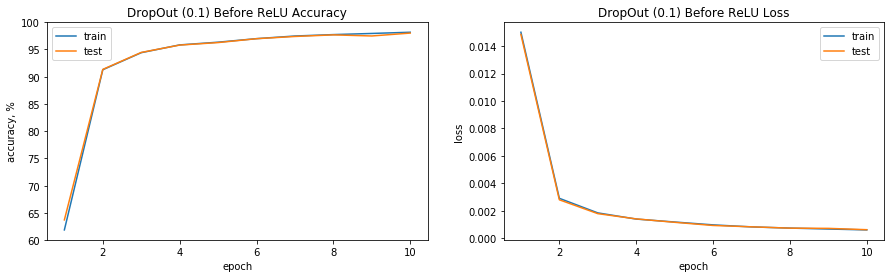

In [30]:
history2_before = learn_model(blocks=1, bn=False, dropout=True, rate=0.1, before_activation=True, title='DropOut (0.1) Before ReLU ')

### Dropout   (no batch_norm, dropout rate = 0.3, inserted before_activation)

0 Done! Train Loss: 0.0038730307581524054, Test Loss: 0.0037542291074991224, Train Accuracy 88.01%, Test Accuracy 88.35%
1 Done! Train Loss: 0.0024241507459431886, Test Loss: 0.0023377973686903716, Train Accuracy 92.42%, Test Accuracy 92.77%
2 Done! Train Loss: 0.0017248963752761483, Test Loss: 0.0016443334410898387, Train Accuracy 94.64%, Test Accuracy 94.88%
3 Done! Train Loss: 0.0014127959671119848, Test Loss: 0.0013858135158661754, Train Accuracy 95.57%, Test Accuracy 95.65%
4 Done! Train Loss: 0.0011717539002808431, Test Loss: 0.0010967445931397378, Train Accuracy 96.38%, Test Accuracy 96.62%
5 Done! Train Loss: 0.0009953296858196457, Test Loss: 0.0010578784116078168, Train Accuracy 96.81%, Test Accuracy 96.42%
6 Done! Train Loss: 0.0009074066412790368, Test Loss: 0.0009473344529047609, Train Accuracy 97.10%, Test Accuracy 96.99%
7 Done! Train Loss: 0.0008408883411747714, Test Loss: 0.000856475713965483, Train Accuracy 97.34%, Test Accuracy 97.23%
8 Done! Train Loss: 0.00075274941

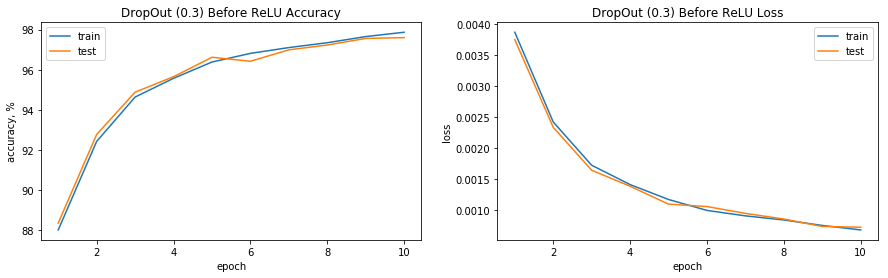

In [57]:
history3_before = learn_model(blocks=1, bn=False, dropout=True, rate=0.3, before_activation=True, title='DropOut (0.3) Before ReLU ')

### Dropout  (no batch_norm, dropout rate = 0.5, inserted before_activation)

0 Done! Train Loss: 0.003996288685997327, Test Loss: 0.003803457424789667, Train Accuracy 87.83%, Test Accuracy 88.71%
1 Done! Train Loss: 0.0026292031195014713, Test Loss: 0.0025151417599990965, Train Accuracy 91.66%, Test Accuracy 92.13%
2 Done! Train Loss: 0.0019612032753725844, Test Loss: 0.0018598707182332873, Train Accuracy 93.80%, Test Accuracy 94.06%
3 Done! Train Loss: 0.0016824250777562459, Test Loss: 0.0016220600532367826, Train Accuracy 94.81%, Test Accuracy 94.81%
4 Done! Train Loss: 0.0013703971491195262, Test Loss: 0.001329184106271714, Train Accuracy 95.65%, Test Accuracy 95.65%
5 Done! Train Loss: 0.0012458496451067428, Test Loss: 0.0011338490409776567, Train Accuracy 96.07%, Test Accuracy 96.37%
6 Done! Train Loss: 0.0011299696411006153, Test Loss: 0.001127260718215257, Train Accuracy 96.46%, Test Accuracy 96.34%
7 Done! Train Loss: 0.0010081174722251793, Test Loss: 0.0009713508112356066, Train Accuracy 96.78%, Test Accuracy 96.92%
8 Done! Train Loss: 0.00091228970813

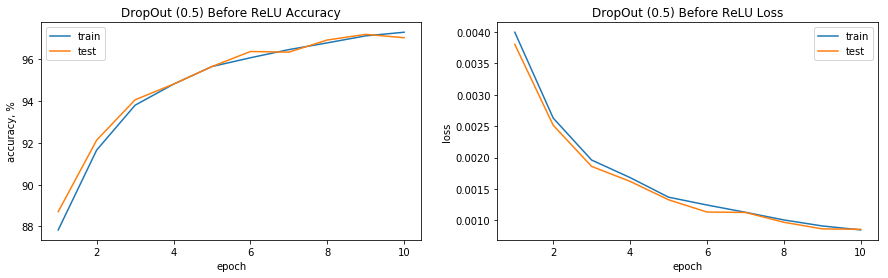

In [32]:
history4_before = learn_model(blocks=1, bn=False, dropout=True, rate=0.5, before_activation=True, title='DropOut (0.5) Before ReLU ')

### Okay now тут чёта сравниваем.

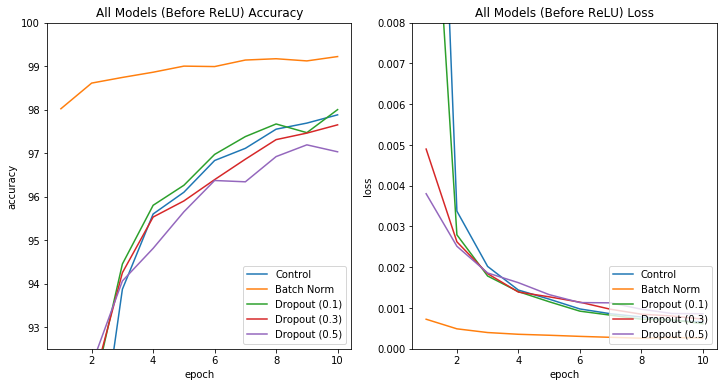

In [52]:
plotAllModels(history0_control, history1_before, history2_before, history3_before, history4_before, "All Models (Before ReLU)")

Чёта какой-то там анализ выбранной хрени. Бачнорм лидирует.

## Okay. Что если мы будем вставлять наш регуляризатор ПОСЛЕ max-pooling'a ?

### BatchNorm (no dropout, inserted after_activation)

0 Done! Train Loss: 0.0011232534246519209, Test Loss: 0.0010094554523471743, Train Accuracy 97.02%, Test Accuracy 97.24%
1 Done! Train Loss: 0.0007230640604781608, Test Loss: 0.0006513081981684081, Train Accuracy 97.99%, Test Accuracy 98.23%
2 Done! Train Loss: 0.0005354625552116582, Test Loss: 0.0004991761346231215, Train Accuracy 98.47%, Test Accuracy 98.44%
3 Done! Train Loss: 0.00044740655674443893, Test Loss: 0.00044208458081120624, Train Accuracy 98.67%, Test Accuracy 98.68%
4 Done! Train Loss: 0.00038332740745972843, Test Loss: 0.0003778013876290061, Train Accuracy 98.92%, Test Accuracy 98.84%
5 Done! Train Loss: 0.00032312475242652, Test Loss: 0.00033636739666690116, Train Accuracy 99.03%, Test Accuracy 98.93%
6 Done! Train Loss: 0.00029869563193448507, Test Loss: 0.00032454325270664413, Train Accuracy 99.15%, Test Accuracy 98.99%
7 Done! Train Loss: 0.0002789789029125435, Test Loss: 0.0003316423338779714, Train Accuracy 99.23%, Test Accuracy 98.91%
8 Done! Train Loss: 0.000255

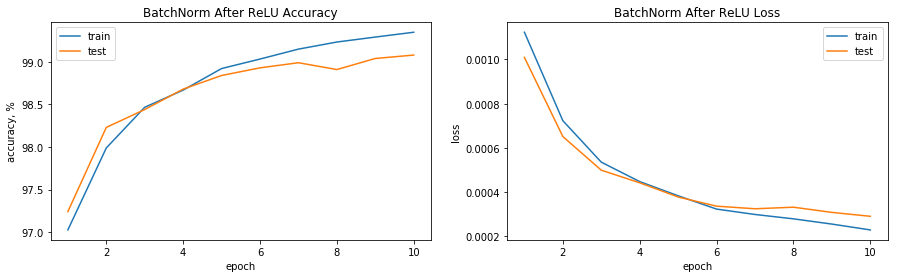

In [39]:
history1_after = learn_model(blocks=1, bn=True, dropout=False, before_activation=False, title='BatchNorm After ReLU ')

### Dropout (no batch_normalization, dropout rate=0.1, inserted after_activation)

0 Done! Train Loss: 0.004851073247690995, Test Loss: 0.004684346170723439, Train Accuracy 84.72%, Test Accuracy 85.44%
1 Done! Train Loss: 0.002577117777491609, Test Loss: 0.0024068280579522252, Train Accuracy 92.02%, Test Accuracy 92.67%
2 Done! Train Loss: 0.0017528412287433942, Test Loss: 0.001668277301453054, Train Accuracy 94.58%, Test Accuracy 94.64%
3 Done! Train Loss: 0.001354000401776284, Test Loss: 0.0012609459786210209, Train Accuracy 95.75%, Test Accuracy 95.94%
4 Done! Train Loss: 0.0010892461497026185, Test Loss: 0.0010987226785626263, Train Accuracy 96.53%, Test Accuracy 96.31%
5 Done! Train Loss: 0.0008871144621012112, Test Loss: 0.0008493132376810535, Train Accuracy 97.30%, Test Accuracy 97.33%
6 Done! Train Loss: 0.0009127030203584581, Test Loss: 0.0009505261567188427, Train Accuracy 96.92%, Test Accuracy 96.78%
7 Done! Train Loss: 0.0007264966634179775, Test Loss: 0.0007654506093589589, Train Accuracy 97.74%, Test Accuracy 97.55%
8 Done! Train Loss: 0.000690845496735

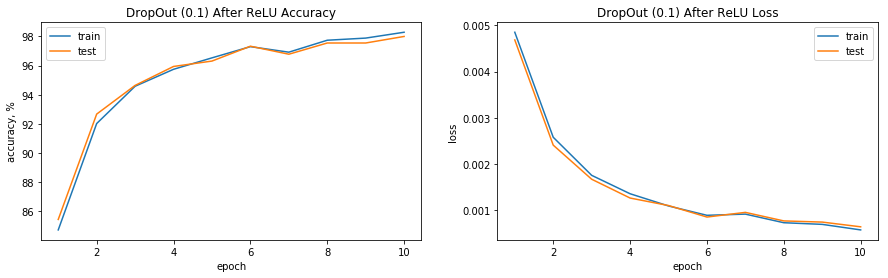

In [44]:
history2_after = learn_model(blocks=1, bn=False, dropout=True, rate=0.1, before_activation=False, title='DropOut (0.1) After ReLU ')

### Dropout (no batch_normalization, dropout rate=0.3, inserted after_activation)

0 Done! Train Loss: 0.003903463593622049, Test Loss: 0.0037233392760157584, Train Accuracy 87.94%, Test Accuracy 88.81%
1 Done! Train Loss: 0.0023454917933791878, Test Loss: 0.0022161577077582477, Train Accuracy 92.47%, Test Accuracy 92.80%
2 Done! Train Loss: 0.0017532951074341933, Test Loss: 0.0016732170978561044, Train Accuracy 94.68%, Test Accuracy 94.85%
3 Done! Train Loss: 0.0013851412483801445, Test Loss: 0.0013340477460063993, Train Accuracy 95.66%, Test Accuracy 95.64%
4 Done! Train Loss: 0.0012906398263759912, Test Loss: 0.0013204130939673633, Train Accuracy 95.93%, Test Accuracy 95.62%
5 Done! Train Loss: 0.0010396844690044721, Test Loss: 0.001019832265889272, Train Accuracy 96.68%, Test Accuracy 96.75%
6 Done! Train Loss: 0.0009417174622261276, Test Loss: 0.0009584851694758982, Train Accuracy 96.94%, Test Accuracy 96.86%
7 Done! Train Loss: 0.0008061174212644497, Test Loss: 0.0008440495763556101, Train Accuracy 97.42%, Test Accuracy 97.41%
8 Done! Train Loss: 0.000745914812

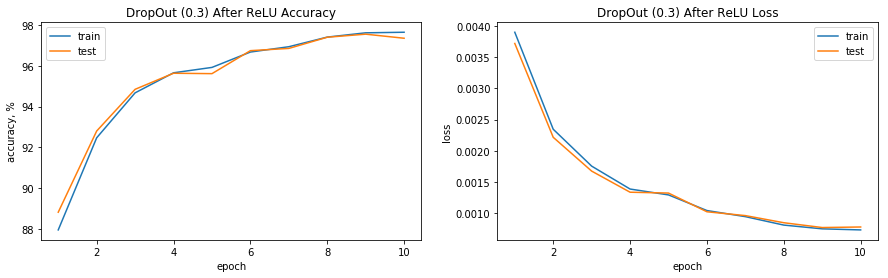

In [41]:
history3_after = learn_model(blocks=1, bn=False, dropout=True, rate=0.3, before_activation=False, title='DropOut (0.3) After ReLU ')

### Dropout (no batch_normalization, dropout rate=0.5, inserted after_activation)

0 Done! Train Loss: 0.0037552821651101113, Test Loss: 0.0035162903767079114, Train Accuracy 88.26%, Test Accuracy 88.84%
1 Done! Train Loss: 0.0025279977132876713, Test Loss: 0.002365382092818618, Train Accuracy 91.95%, Test Accuracy 92.59%
2 Done! Train Loss: 0.0019864532007525366, Test Loss: 0.0019032994277775287, Train Accuracy 93.72%, Test Accuracy 93.89%
3 Done! Train Loss: 0.0015250653217236201, Test Loss: 0.0014303613340947777, Train Accuracy 95.20%, Test Accuracy 95.43%
4 Done! Train Loss: 0.0013380298337899148, Test Loss: 0.0012501889153616504, Train Accuracy 95.70%, Test Accuracy 96.02%
5 Done! Train Loss: 0.0011335893934282164, Test Loss: 0.0011501189110800624, Train Accuracy 96.44%, Test Accuracy 96.16%
6 Done! Train Loss: 0.0010137340891019752, Test Loss: 0.0010216318709077314, Train Accuracy 96.86%, Test Accuracy 96.63%
7 Done! Train Loss: 0.0010082884278303633, Test Loss: 0.0009355676468927413, Train Accuracy 96.86%, Test Accuracy 97.06%
8 Done! Train Loss: 0.00088245862

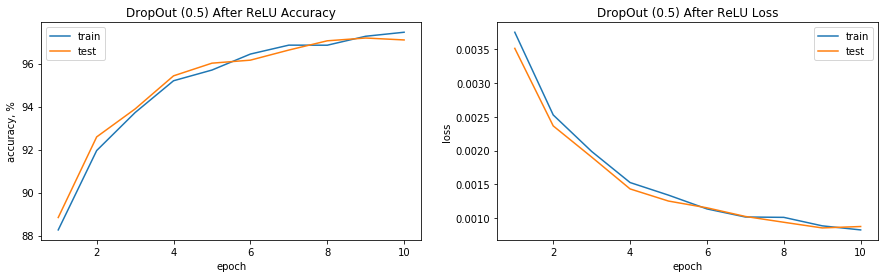

In [42]:
history4_after = learn_model(blocks=1, bn=False, dropout=True, rate=0.5, before_activation=False, title='DropOut (0.5) After ReLU ')

### Okay now тут чёта сравниваем.

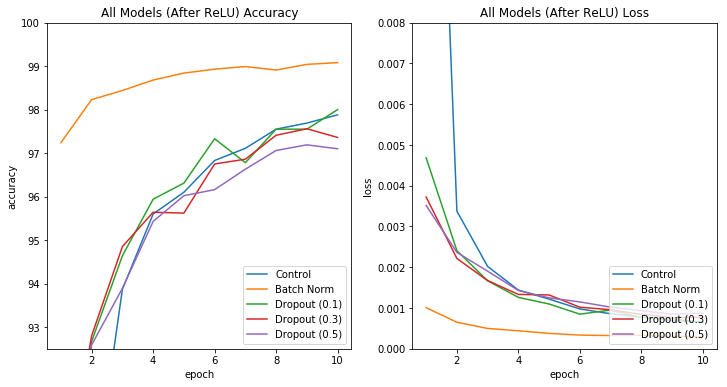

In [53]:
plotAllModels(history0_control, history1_after, history2_after, history3_after, history4_after, "All Models (After ReLU)")

### Общие наблюдения

Можно провести кое-какие промежуточные итоги, общие для всех экспериментов с обучением.

Например стоит заметить, что ни в одном из случаев явного переобучения наблюдать мы не можем. (Данный момент фиксируется, когда графики accuracy для train и test сначала монотоноо возрастают, и затем, в какой-то момент accuracy на test резко падает, но в то же время, accuracy на train всё ещё продолжает монотонно расти. При этом Loss как для train, так и для test при первоначальном монотонном убывании, для test - подскочит вверх, прервав его.)

Однако было задействовано около 10 эпох (шаблон обертки функции обучения модели позволяет настраивать количество эпох), и результат по % accuracy все модели показали довольно высокий.

## Вывод
Основной посыл исследования заключается в следующем. Эфективное обучение нейронных сетей: по мере распространения сигнала по сети, даже если мы нормализовали его на входе, пройдя через внутренние слои, он может сильно исказиться как по матожиднию, так и по дисперсии (данное явление называется внутренним ковариационным сдвигом), что чревато серьезными несоответствиями между градиентами на различных уровнях.

По результирующим графикам становится очевидно, что batch-normalization в обоих из случаев ведёт себя довольно хорошо и стабильно лучше как Dropout'a с различными параметрами вероятности, так и Control - обучения без регуляризации вовсе. Дело в том, что Batch-Normalization действительно метод регуляризации данных в нейронных сетях, осуществляющийся путем нормализации до  $N\left(0, 1\right)$ распределения каждого batch'a данных, подаваемых в функции в качестве входа на каждом слое.

Таким образом действительно, нормализуем входные данные чтобы иметь нулевое мат.ожидание, и единичную дисперсию.

К сожалению сказать что-то плохое в сторону Dropout'a и назвать какое-то логичное объяснение его относительно плохому характеру - сложно. Проблема в том, что для него (Dropout'a) мало что исследовано, и тем мало доказано материалов необходимых для доказательства его сходимости к оптимальному решению. К сожалению Dropout находясь на пике своей популярности пару лет назад, очень быстро потерял её. Тем не менее это не мешает очень частому использованию Dropout'ов в качестве улучшающего регуляризатора, в паре с Batch_Norm, в крупных моделях нейронных сетей, когда нужно стакать несколько различных архитектур, и вероятность увеличения разброса сильно возрастает.